In [1]:
CUDA_LAUNCH_BLOCKING="1"

import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [2]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.size[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def dice_loss(inputs, target):
    num = target.size(0)
    chans = target.size(1)
    inputs = inputs.reshape(num*chans, -1)
    target = target.reshape(num*chans, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / (num*chans)
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        return self.sig(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    def __init__(self, folder_path, interp_size = None, scale = None):
        super(DatasetSegmentation, self).__init__()
        self.interp_size = interp_size
        self.scale = scale
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)

        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        if self.interp_size:
            data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
            label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        elif self.scale:
            data = F.interpolate(data.unsqueeze(0), scale_factor=self.scale).squeeze(0)
            label = F.interpolate(label.unsqueeze(0), scale_factor=self.scale).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
ds_train = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'train'), scale=0.5)
ds_test = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'test'), scale=0.5)
ds_val = DatasetSegmentation(os.path.join('data', 'yeast_processed_norm_area_50', 'val'), scale=0.5)

In [6]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [7]:
sample = ds_train.__getitem__(12)

C:\Users\mawil\Anaconda3\envs\SYSC4907\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


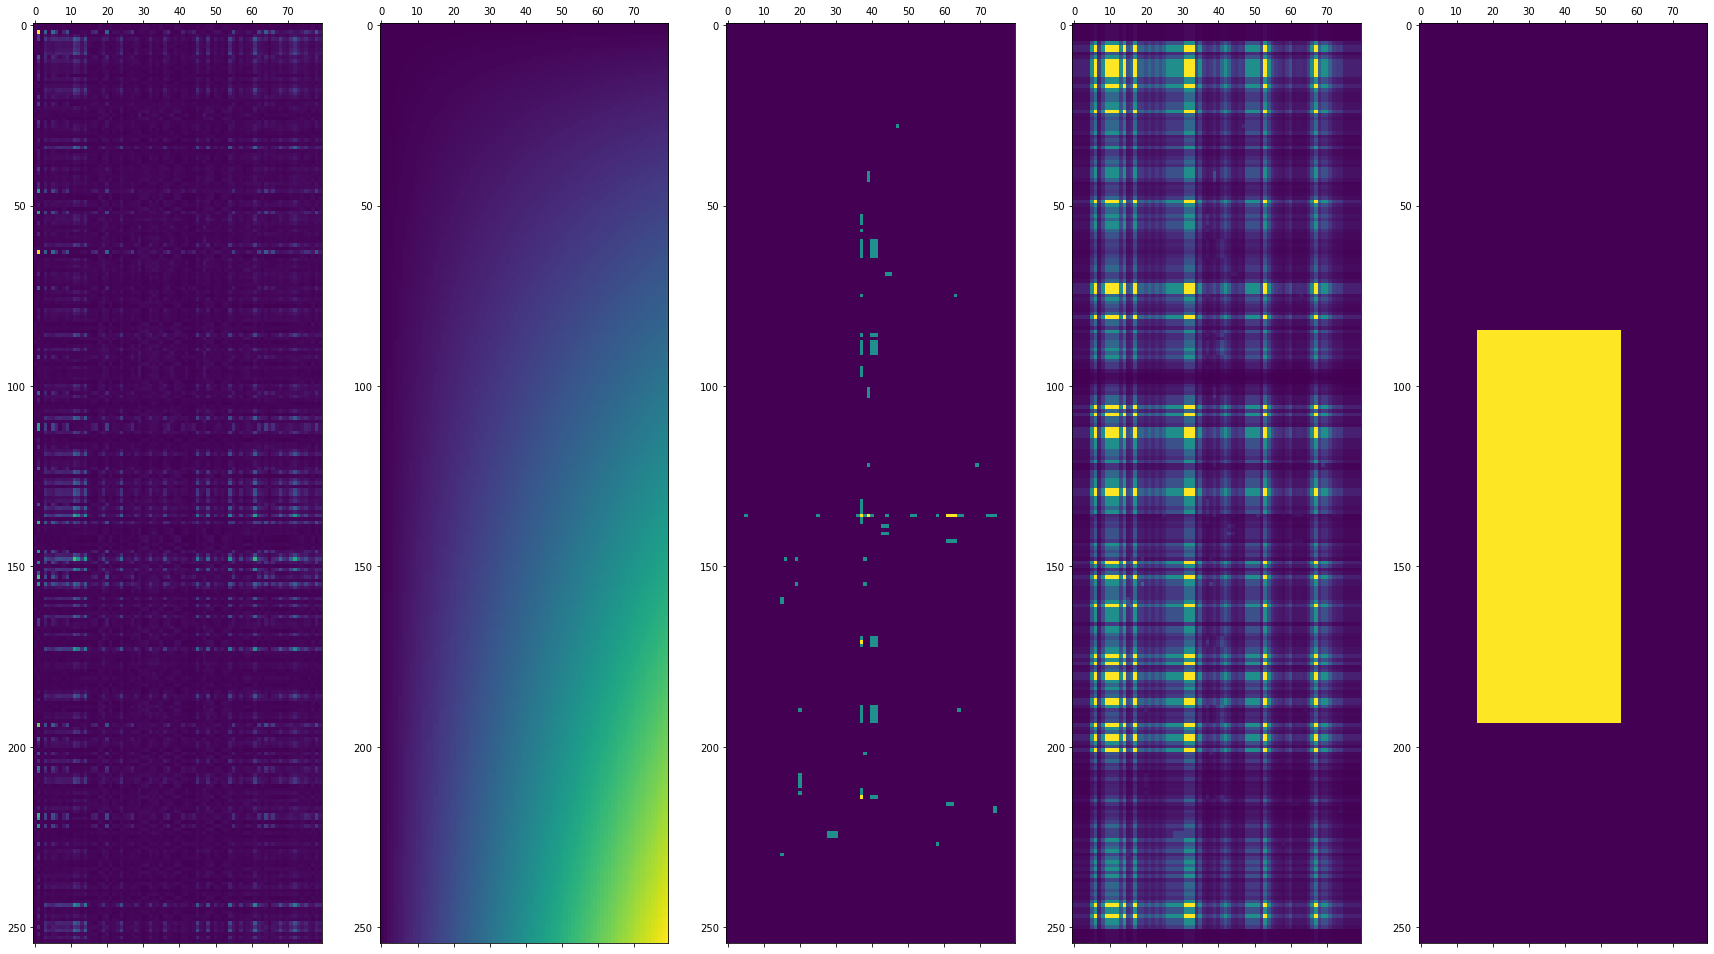

In [8]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0])
axs[1].matshow(sample[0][1])
axs[2].matshow(sample[0][2])
axs[3].matshow(sample[0][3])
axs[4].matshow(sample[1][0])
plt.show()

In [9]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=1, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

# Setup Model 

In [10]:
model = UNet(n_classes=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [12]:
criterion = nn.BCELoss()

Setup optimizer

In [13]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [14]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

In [16]:
from tqdm.autonotebook import tqdm

epochs = 50

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')

# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        torch.save(model.state_dict(), './models/unet/best_model.pth')
    # Change the learning rate
    scheduler.step( )
    # Print the results
    

    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])

# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

Start train...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/892 [00:00<?, ?it/s]

epoch 0 train loss 0.4914688469482911 val loss 0.4611610820783036
epoch 1 train loss 0.4821708712208966 val loss 0.4602140925292458
epoch 2 train loss 0.4812865471091506 val loss 0.4696806935327394
epoch 3 train loss 0.4816282061617738 val loss 0.4601779079863003
epoch 4 train loss 0.48179361048768454 val loss 0.47604752651282717
epoch 5 train loss 0.4798610341472075 val loss 0.46377168675618513
epoch 6 train loss 0.4796652540798412 val loss 0.46057224007589476
epoch 7 train loss 0.48016165155132257 val loss 0.4602314809869443
epoch 8 train loss 0.48014137852151834 val loss 0.4634777535019176
epoch 9 train loss 0.48042693099366174 val loss 0.4602415815794042
epoch 10 train loss 0.4792371353660731 val loss 0.4601832116022706
epoch 11 train loss 0.47953308991787147 val loss 0.4602384951763919
epoch 12 train loss 0.4791360615748461 val loss 0.46288492770067285
epoch 13 train loss 0.478861662955963 val loss 0.46146632491477896
epoch 14 train loss 0.4794651046061195 val loss 0.4602973872263

KeyboardInterrupt: 

# Evaluate

In [17]:
checkpoint = torch.load('./models/unet/best_model.pth',
                        map_location=torch.device('cpu'))

model.load_state_dict(checkpoint)
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [18]:
def plot_mask(mask_cpu, axx, round=False):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    axx.matshow(mask_cpu)

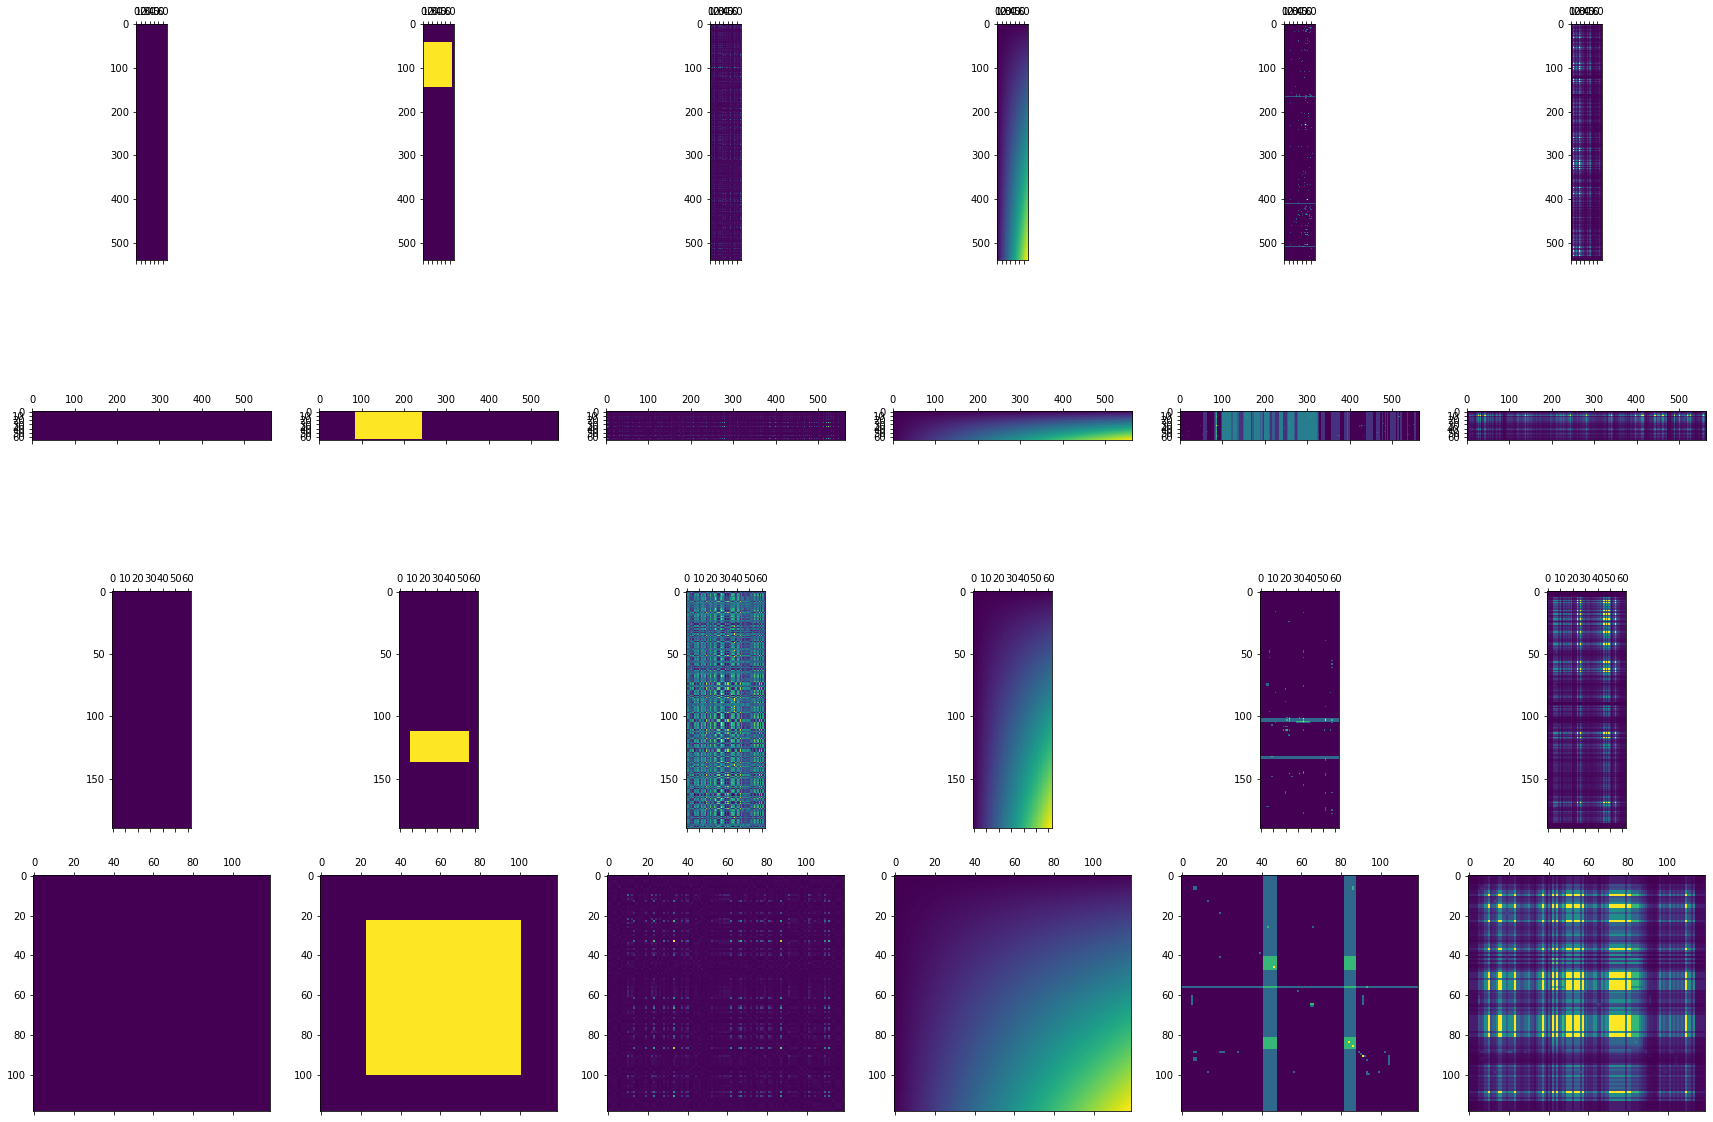

In [19]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Function to compute the dice accuracy

In [20]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}')

# Compute dice accuracy for train, validation and test data

In [21]:
compute_acc(test_dataloader, model)

Loss: 1.309458335240682, Accuracy (dice): 0.1436605653750449


In [22]:
compute_acc(train_dataloader, model)

Loss: 1.32710879920844, Accuracy (dice): 0.15155747558172686


In [24]:
compute_acc(val_dataloader, model)

Loss: 1.3137225263885088, Accuracy (dice): 0.14635908040799867


In [ ]:
tor